In [2]:
# Common Imports
import numpy as np
import pandas as pd
import os
import io
import warnings

#skearn importts
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron

from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV

from sklearn.metrics import hinge_loss
from sklearn.metrics import roc_curve
from sklearn.metrics import hinge_loss
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.metrics import make_scorer

# plots
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns

### Data Loading

In [3]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

The data matrix X and the respective label vector y need to be converted to numpy array

In [4]:
X = X.to_numpy()
y = y.to_numpy()

Let's look at information like number of features, number of classes etc about the dataset.

In [5]:
target_names = np.unique(y)
print('Number of samples: {0}, type: {1}'.format(X.shape[0], X.dtype))
print('Number of features: {0}'.format(X.shape[1]))
print('Minimum:{0}, Maximum:{1}'.format(np.min(X), np.max(X)))
print('Number of classes: {0}, type:{1}'.format(len(target_names), y.dtype))
print('Labels: {0}'.format(target_names))

Number of samples: 70000, type: float64
Number of features: 784
Minimum:0.0, Maximum:255.0
Number of classes: 10, type:object
Labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


* The feature values are pixel values of `28 x 28` images. Each image comes with `28 x 28`pixels. `28 x 28 = 784` which are the feature for each sample, and the value ranges between 0 and 255.

Let's first scale the values to a [0,1]. We can use either MinMaxScaler or MaxAbsScaler.

In [6]:
X = MinMaxScaler().fit_transform(X)
print('Minimum:{0}, Maximum:{1}'.format(np.min(X), np.max(X)))

Minimum:0.0, Maximum:1.0


### Visualisation
Let's pick a few images and display them

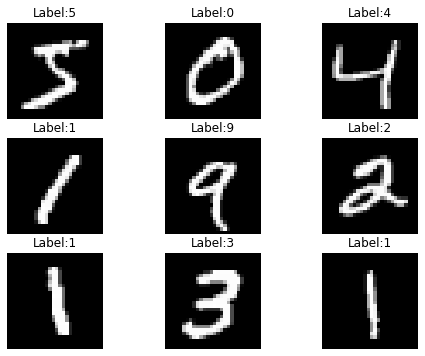

In [7]:
num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows = factor, ncols = factor, figsize = (8, 6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i, j].imshow(X[index + j].reshape(28, 28), cmap = 'gray')
        ax[i, j].set_title('Label:{0}'.format(str(y[index + j])))
        ax[i, j].set_axis_off()

### Data Splitting
we take 60k for train and 10k for test. Since the images are already randomly shuffled we need not use train_test_spit.

In [8]:
x_train, x_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Before proceeding further, we need to check whether the dataset is balanced or imbalanced. We can do it by plotting the distribution of sampls in each classes.

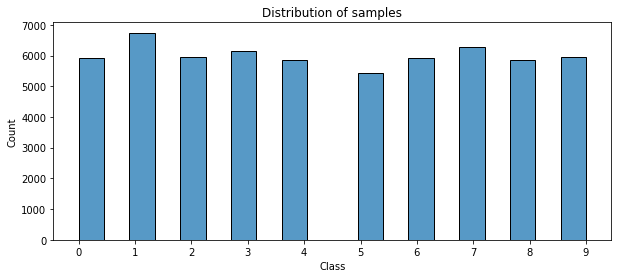

In [9]:
plt.figure(figsize=(10,4))
sns.histplot(data = np.int8(y_train), binwidth = 0.45, bins = 11)
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

roughly each class has 6k samples 

### Binary Classification: 0-Detector
#### Modifying Labels
* We are trying to implement binary classifier which can detect 0 from the handwritten digits.
* We will relabel the samples such that the label 0 will be chnaged to 1 and all otherr labels(1-9) will be changed to -1.

In [10]:
# Initialize new variable names with all -1
y_train_0 = -1*np.ones((len(y_train)))
y_test_0 = -1*np.ones((len(y_test)))

print(y_train_0, y_test_0)

[-1. -1. -1. ... -1. -1. -1.] [-1. -1. -1. ... -1. -1. -1.]


In [11]:
#find indices of the digit 0 image
train_indx_0 = np.where(y_train == '0')
y_train_0[train_indx_0] = 1

test_indx_0 = np.where(y_test == '0')
y_test_0[test_indx_0] = 1

print('new train --> ',  train_indx_0[0][:10], y_train_0[:10])
print('new test --> ', test_indx_0[0][:10], y_test_0[:10])

new train -->  [ 1 21 34 37 51 56 63 68 69 75] [-1.  1. -1. -1. -1. -1. -1. -1. -1. -1.]
new test -->  [  3  10  13  25  28  55  69  71 101 126] [-1. -1. -1.  1. -1. -1. -1. -1. -1. -1.]


sanity check 

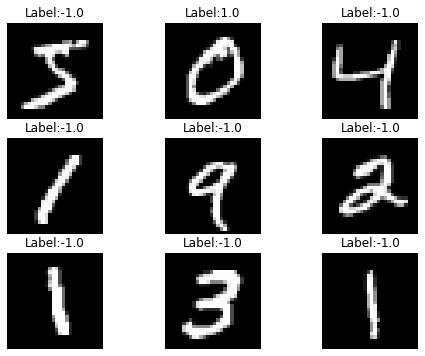

In [12]:
num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows = factor, ncols = factor, figsize = (8, 6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i, j].imshow(X[index + j].reshape(28, 28), cmap = 'gray')
        ax[i, j].set_title('Label:{0}'.format(str(y_train_0[index + j])))
        ax[i, j].set_axis_off()

#### Baseline Models
Let's quickly construct a baseline model witht he following rule

1. Count the number of samples per class
2. The model always outputs the class which has highest number of samples.
3. Then calculate teh accuracy of the baseline model.

In [13]:
num_pos = len(np.where(y_train_0 == 1)[0])
num_neg = len(np.where(y_train_0 == -1)[0])
print(num_pos, num_neg) # most frequent is negative ==> non zero 

5923 54077


In [14]:
base_clf = DummyClassifier(strategy='most_frequent')
base_clf.fit(x_train, y_train_0)
print('Training accuracy:{0:0.2f}'.format(base_clf.score(x_train, y_train_0)))
print('Testing accuracy:{0:0.2f}'.format(base_clf.score(x_test, y_test_0)))

Training accuracy:0.90
Testing accuracy:0.90


In [15]:
print(f"total -ve (54077)/ total(60000) ==> {round(54077/60000, 2)}")

total -ve (54077)/ total(60000) ==> 0.9


### Perceptron

In [16]:
#Instantiate the model
bin_clf  = Perceptron(max_iter=100, random_state=1729)

#Train
bin_clf.fit(x_train, y_train_0)

#Results
print('Dimension of weight w: {0}'.format(bin_clf.coef_.shape))
print('Bias: {0}'.format(bin_clf.intercept_))
print('The loss function: {0}'.format(bin_clf.loss_function_))

Dimension of weight w: (1, 784)
Bias: [-108.]
The loss function: <sklearn.linear_model._sgd_fast.Hinge object at 0x000001834E40A130>


In [17]:
print('weights: {0}'.format(bin_clf.coef_))

weights: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00 -1.02362205e-01 -1.93725490e+00  2.69803922e+00
   8.09803922e+00  3.31372549e+00 -8.78431373e-01  6.56078431e+00
   1.83294118e+01  8.71764706e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  2.00000000e+00
 

In [18]:
print('Training Accuracy: ', bin_clf.score(x_train, y_train_0))
print('Test Accuracy: ', bin_clf.score(x_test, y_test_0))

Training Accuracy:  0.99095
Test Accuracy:  0.989


Display predictions

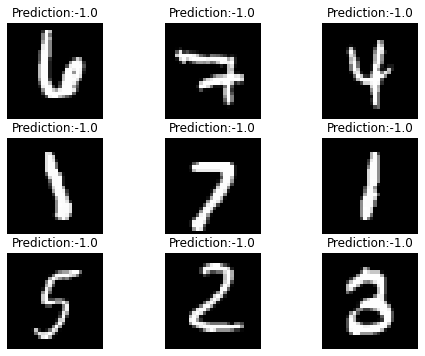

In [19]:
y_hat_test_0 = bin_clf.predict(x_test)

num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows = factor, ncols = factor, figsize = (8, 6))
idx_offset = np.random.randint(0, int(len(x_test)/2)) # take "num_images" starting from the index "idx_offset"
for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i, j].imshow(x_test[index + j].reshape(28, 28), cmap = 'gray')
        ax[i, j].set_title('Prediction:{0}'.format(str(y_hat_test_0[index + j])))
        ax[i, j].set_axis_off()

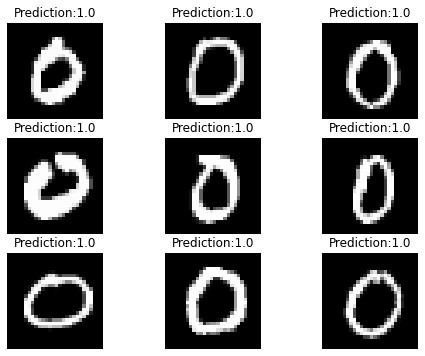

In [20]:
indx_0 = np.where(y_test_0 == 1)

zeroImgs = x_test[indx_0[0]]
zeroLabls = y_hat_test_0[indx_0[0]]

num_images = 9 # Choose a square number
factor = int(np.sqrt(num_images))
fig, ax = plt.subplots(nrows = factor, ncols = factor, figsize = (8, 6))
idx_offset = 0 # take "num_images" starting from the index "idx_offset"
for i in range(factor):
    index = idx_offset + i*(factor)
    for j in range(factor):
        ax[i, j].imshow(zeroImgs[index + j].reshape(28, 28), cmap = 'gray')
        ax[i, j].set_title('Prediction:{0}'.format(str(zeroLabls[index + j])))
        ax[i, j].set_axis_off()

Confusion matrix

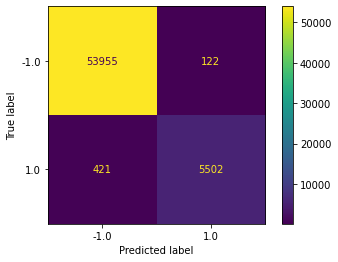

In [21]:
y_hat_train_0 = bin_clf.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')
plt.show()

Precision Recall

In [22]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

precision = tp/(tp + fp)
recall = tp/(tp + fn)
accuracy = (tn + tp)/ (tn + fn + fp + tp)

print('Precision: ', precision)
print('Recall: ', recall)
print('Accuracy: ', accuracy)

Precision:  0.9783072546230441
Recall:  0.9289211548201924
Accuracy:  0.99095


Cross validation

In [23]:
bin_clf = Perceptron(max_iter=100, random_state=1729)
scores = cross_validate(bin_clf, x_train, y_train_0, cv=5, 
                        scoring=['precision', 'recall', 'f1'],
                        return_estimator=True)

pprint(scores)

{'estimator': [Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729),
               Perceptron(max_iter=100, random_state=1729)],
 'fit_time': array([1.12959957, 2.33634424, 1.63257623, 1.44312119, 1.88405943]),
 'score_time': array([0.20749426, 0.03903031, 0.04047799, 0.04049373, 0.0377624 ]),
 'test_f1': array([0.95238095, 0.91666667, 0.94915254, 0.94117647, 0.95091763]),
 'test_precision': array([0.95890411, 0.98828125, 0.95319149, 0.95090439, 0.96200345]),
 'test_recall': array([0.94594595, 0.85472973, 0.94514768, 0.93164557, 0.94008439])}


In [24]:
print('f1, avg:{0:.2f}, std:{1:.3f}'.format(scores['test_f1'].mean(), scores['test_f1'].std()))
print('precision, avg:{0:.2f}, std:{1:.2f}'.format(scores['test_precision'].mean(), scores['test_precision'].std()))
print('recall, avg:{0:.2f}, std:{1:.2f}'.format(scores['test_recall'].mean(), scores['test_recall'].std()))


f1, avg:0.94, std:0.013
precision, avg:0.96, std:0.01
recall, avg:0.92, std:0.03


Let's pick the first estimator as it has the best scores during the cross validation and hope that it has better performance on the test data

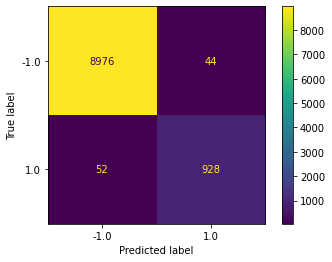

In [25]:
bin_clf = scores['estimator'][0]
y_hat_test_0 = bin_clf.predict(x_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0, y_hat_test_0, values_format='.5g')
plt.show()

In [26]:
print('Precision %.2f' %precision_score(y_test_0, y_hat_test_0))
print('Recall %.2f' %recall_score(y_test_0, y_hat_test_0))

Precision 0.95
Recall 0.95


Another way to generalise

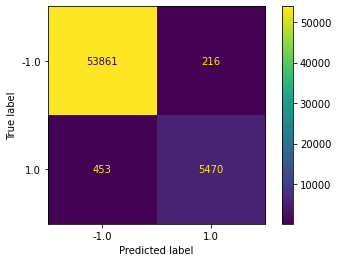

In [27]:
y_hat_train_0 = cross_val_predict(bin_clf, x_train, y_train_0, cv=5)

cm_display = ConfusionMatrixDisplay.from_predictions(y_train_0, y_hat_train_0, values_format='.5g')
plt.show()

In [28]:
cf_matrix = cm_display.confusion_matrix
tn = cf_matrix[0,0]
fn = cf_matrix[1,0]
fp = cf_matrix[0,1]
tp = cf_matrix[1,1]

precision = tp/(tp + fp)
recall = tp/(tp + fn)
accuracy = (tn + tp)/ (tn + fn + fp + tp)
f1 = (2 * precision * recall) / (recall + precision)

print('Precision: ', precision)
print('Recall: ', recall)
print('Accuracy: ', accuracy)
print('f1 score : ', f1)

Precision:  0.9620119591980303
Recall:  0.9235184872530812
Accuracy:  0.98885
f1 score :  0.9423722973555001


In [29]:
print('Precision %.2f' %precision_score(y_train_0, y_hat_train_0))
print('Recall %.2f' %recall_score(y_train_0, y_hat_train_0))
print('-'*50)
print(classification_report(y_train_0, y_hat_train_0))

Precision 0.96
Recall 0.92
--------------------------------------------------
              precision    recall  f1-score   support

        -1.0       0.99      1.00      0.99     54077
         1.0       0.96      0.92      0.94      5923

    accuracy                           0.99     60000
   macro avg       0.98      0.96      0.97     60000
weighted avg       0.99      0.99      0.99     60000



##### Precision - Recall Tradeoff

* increase precision --> drop in recall
* increase recall --> drop in precision 

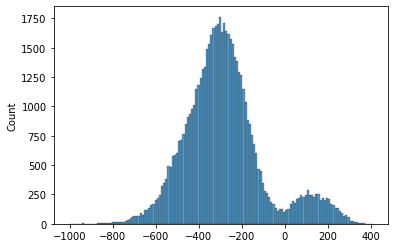

In [30]:
bin_clf = Perceptron(random_state=1729)
bin_clf.fit(x_train, y_train_0)
y_scores = bin_clf.decision_function(x_train) # values of linear combination ==> y = Wt * X
sns.histplot(np.sort(y_scores))
plt.show()

* Class imbalance
* Suppose threshold talkes the value of -600, then all the samples having score greater than -600 is set to 1 and less than it is set to -1.
* On the other hand, if the threshold takes the value of, say, 400. Then, the number of false negatives will increase and recall will reduce to a great extend.

Let's see it in action

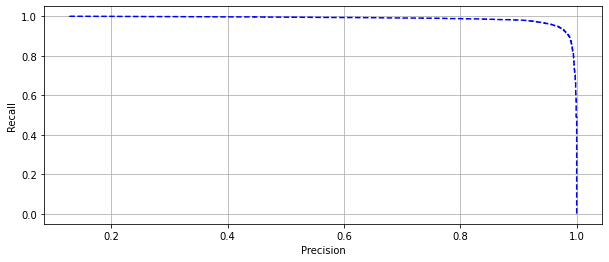

In [31]:
precisions, recalls, thresholds = precision_recall_curve(y_train_0, y_scores, pos_label=1)

plt.figure(figsize=(10,4))
plt.plot(precisions[:-1], recalls[:-1], "b--")
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid(True)
plt.show()

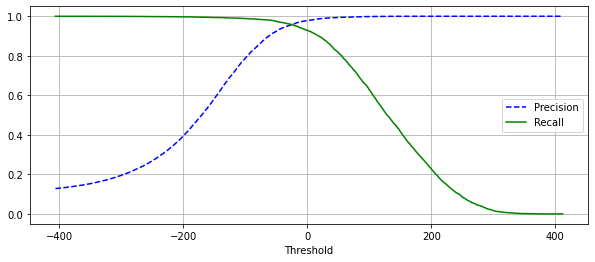

In [32]:
plt.figure(figsize=(10,4))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel('Threshold')
plt.grid(True)
plt.legend()
plt.show()

In [33]:
idx_th = np.where(np.logical_and(thresholds > 0, thresholds < 1))
print('precision for zero threshold : ', precisions[idx_th[0][0]])

precision for zero threshold :  0.9783072546230441


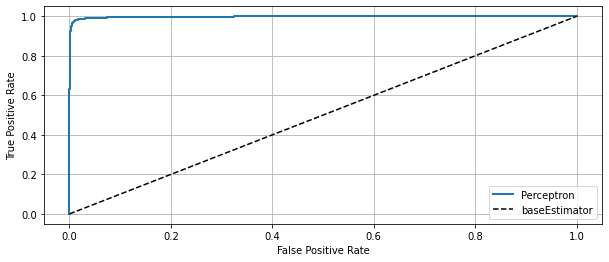

In [34]:
fpr, tpr, thresholds = roc_curve(y_train_0, y_scores)
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, linewidth=2, label = 'Perceptron')
plt.plot([0, 1], [0,1], 'k--', label = 'baseEstimator')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.legend()
plt.show()

#### Warm start vs Cold start 

cold start 

In [35]:
bin_clf.fit(x_train, y_train_0)
y_hat_train_0 = bin_clf.predict(x_train)
print('accuracy ', bin_clf.score(x_test, y_test))

accuracy  0.0


warm start --> weights obtained from the previous run of perceptron is used to initialize the weights. this speeds up the process and used for batch learning 

In [36]:
bin_clf_warm = Perceptron(max_iter= 100, random_state= 1729, warm_start= True)
bin_clf_warm.fit(x_train, y_train)
print('accuracy ', bin_clf_warm.score(x_train, y_train))

accuracy  0.9041333333333333


Make Pipeline

In [37]:
pipeline = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('bin_clf', Perceptron())
])

pipeline.fit(x_train, y_train_0)


Pipeline(steps=[('scaler', MinMaxScaler()), ('bin_clf', Perceptron())])

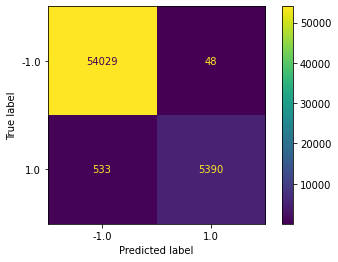

In [41]:
y_hat_train_0 = pipeline.predict(x_train)
cm_display = ConfusionMatrixDisplay.from_predictions(
    y_train_0, y_hat_train_0, values_format = '.5g'
)
plt.show()

### Iteration vs Loss Curve

here we use `partial_fit` to obtain the learning curve. 

In [53]:
iterations = 100 
bin_clf1 = Perceptron(max_iter = 1000, random_state = 2094)
loss_clf1 = []

for i in range(iterations) : 
    bin_clf1.partial_fit(x_train, y_train_0, classes = np.array([1, -1]))
    y_hat_0 = bin_clf1.decision_function(x_train)
    loss_clf1.append(hinge_loss(y_train_0, y_hat_0))

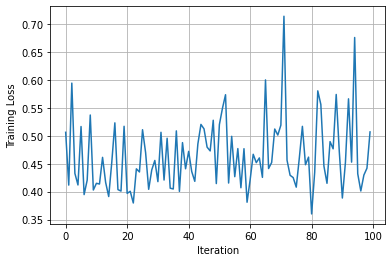

In [47]:
plt.figure()
plt.plot(np.arange(iterations), loss_clf1)
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.show()


### GridSearch

In [48]:
scoring = make_scorer(hinge_loss, greater_is_better= False)
lr_grid = [1/2**n for n in range(1, 6)]
bin_clf_gscv = GridSearchCV(Perceptron(), param_grid= {"eta0" : lr_grid}, scoring= scoring, cv = 5)
bin_clf_gscv.fit(x_train, y_train_0)

GridSearchCV(cv=5, estimator=Perceptron(),
             param_grid={'eta0': [0.5, 0.25, 0.125, 0.0625, 0.03125]},
             scoring=make_scorer(hinge_loss, greater_is_better=False))

In [49]:
pprint(bin_clf_gscv.cv_results_)

{'mean_fit_time': array([2.15091624, 2.30392098, 1.91197124, 2.15633826, 2.16798921]),
 'mean_score_time': array([0.03600621, 0.04882379, 0.04230719, 0.0419908 , 0.10761571]),
 'mean_test_score': array([-0.0285    , -0.0285    , -0.02643333, -0.03066667, -0.0421    ]),
 'param_eta0': masked_array(data=[0.5, 0.25, 0.125, 0.0625, 0.03125],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'eta0': 0.5},
            {'eta0': 0.25},
            {'eta0': 0.125},
            {'eta0': 0.0625},
            {'eta0': 0.03125}],
 'rank_test_score': array([2, 2, 1, 4, 5]),
 'split0_test_score': array([-0.02166667, -0.02166667, -0.02166667, -0.02166667, -0.02166667]),
 'split1_test_score': array([-0.0395, -0.0395, -0.0395, -0.0395, -0.0395]),
 'split2_test_score': array([-0.02816667, -0.02816667, -0.02816667, -0.02816667, -0.02816667]),
 'split3_test_score': array([-0.023     , -0.023     , -0.023     , -0.04416667, -0.04416667]),
 

0.125 has got rank 1 so we try that as `eta0`

In [60]:
iterations = 100 
bin_clf1 = Perceptron(max_iter = 1000, random_state = 2094, eta0 = 0.125)
loss_clf2 = []

for i in range(iterations) : 
    bin_clf1.partial_fit(x_train, y_train_0, classes = np.array([1, -1]))
    y_hat_0 = bin_clf1.decision_function(x_train)
    loss_clf2.append(hinge_loss(y_train_0, y_hat_0))

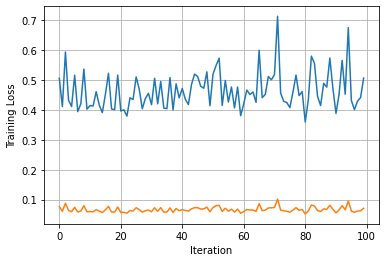

In [61]:
plt.figure()
plt.plot(np.arange(iterations), loss_clf1, label = 'eta0 = 1')
plt.plot(np.arange(iterations), loss_clf2, label = 'eta0 = 0.125')
plt.grid(True)
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.show()


training loss is much much lower in the grid search `eta0`

In [62]:
best_bin_clf = bin_clf_gscv.best_estimator_

y_hat_train_0 = best_bin_clf.predict(x_train)
print(classification_report(y_train_0, y_hat_train_0))

              precision    recall  f1-score   support

        -1.0       0.99      0.99      0.99     54077
         1.0       0.95      0.95      0.95      5923

    accuracy                           0.99     60000
   macro avg       0.97      0.97      0.97     60000
weighted avg       0.99      0.99      0.99     60000



Visualize weight vectors

In [63]:
bin_clf = Perceptron(max_iter = 100)
bin_clf.fit(x_train, y_train_0)
y_hat_train_0 = bin_clf.predict(x_train)

In [75]:
idx_n = np.where(y_train_0 == -1)
idx_pred_p = np.where(y_hat_train_0 == 1)
idx_pred_n = np.where(y_hat_train_0 == -1)
idx_fp = np.intersect1d(idx_n, idx_pred_p)
idx_tn = np.intersect1d(idx_n, idx_pred_n)

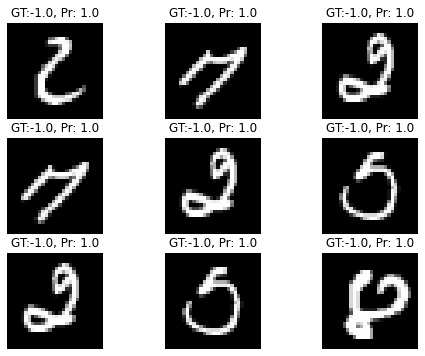

In [77]:
fig, ax = plt.subplots(nrows = factor, ncols = factor, figsize = (8, 6))
idx_offset = 0
for i in range(3):
    index = idx_offset + i
    for j in range(factor):
        ax[i, j].imshow(x_train[idx_fp[index + j]].reshape(28, 28), cmap = 'gray')
        ax[i, j].set_title('GT:{0}, Pr: {1}'.format(str(y_train_0[idx_fp[index + j]]), str(y_hat_train_0[idx_fp[index + j]])))
        ax[i, j].set_axis_off()

In [78]:
from matplotlib.colors import Normalize

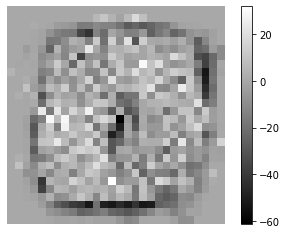

In [79]:
w = bin_clf.coef_
w_matrix = w.reshape(28, 28)
fig = plt.figure()
plt.imshow(w_matrix, cmap = 'gray')
plt.grid(False)
plt.axis(False)
plt.colorbar()
plt.show()

activation map vs digit 

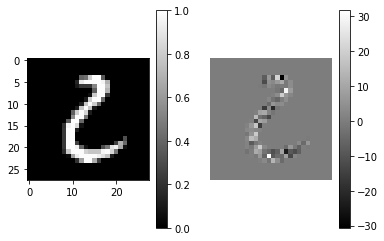

In [80]:
activation = w * x_train[idx_fp[0]].reshape(1, -1)
lin_out = activation.reshape(28, 28)
plt.subplot(1, 2, 1)
plt.imshow(x_train[idx_fp[0]].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(lin_out, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.axis(False)
plt.show()

In [81]:
print(np.sum(lin_out) + bin_clf.intercept_) # > 0 ==> 0

[22.90520569]


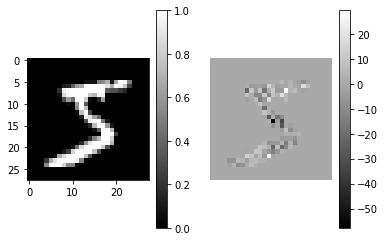

In [82]:
activation = w * x_train[idx_tn[0]].reshape(1, -1)
lin_out = activation.reshape(28, 28)
plt.subplot(1, 2, 1)
plt.imshow(x_train[idx_tn[0]].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(lin_out, cmap='gray')
plt.colorbar()
plt.grid(False)
plt.axis(False)
plt.show()

In [83]:
print(np.sum(lin_out) + bin_clf.intercept_) # < 0 ==> non zero 

[-293.33960784]
